# Contrastive Hebbian Learning

Contrastive Hebbian Learning (CHL) is an algorithm that can be used to perform supervised learning in a neural network. It unites the power of backpropagation with the plausibility of Hebbian learning, and is thus a favorite of researchers in computational neuroscience. In terms of power, Xie (2006) has shown that, under most conditions, CHL is actually equivalent to backpropagation.

## "Learn" and "Unlearn" phases

CHL works by performing Hebbian updates in two distinct phases, which are indicated as the __Learn__ (+) or the __Unlearn__ (-) phases. Synaptic weights are updated according to the difference of the two phases:

 $$
 w_{i,j} \leftarrow w_{i,j} + \eta (y^+_i y^+_j - y^-_i y^-_j)
 $$

Where $y$ represents, as usual, the output of a neuron.

## Synchronous and Asynchronous

In the canonical equation (above), the two terms $y^+_i y^+_j$ and $y^-_i y^-_j$ are computed at different times but updated at the same moment. Because of this, the canonical form is called __synchronous__. This form is efficient but implausible, because it requires storing the products $y^+_i y^+_j$ and $-y^-_i y^-_j$ until the update is performed.

A more plausible alternative is to perform __asynchronous__  updates, with the product $y_i y_j$ because it is calculated and used immediately (just like in canonical Hebbian learning) with the sign of the update being dependent upon the phase.

 $$
 w_{i,j} \leftarrow w_{i,j} +
 \begin{cases}
  + \eta (y_i y_j) & \mathrm{if~phase~is~Learn} \\
  - \eta (y_i y_j) & \mathrm{if~phase~is~Unlearn}
 \end{cases}
 $$

 ## Connectivity

Because of its very nature, CHL requires the network to be __recurrent__, that is, synaptic matrices that connect two adjacent layers both forward and backward.

In turn, recurrent networks are intrinsically unstable, as they require multiple passes to converge towards a stable solution. The number of passes is sometimes used as a proxy for response times or similar behavioral measures.

 ## The Network

The CHL version of the XOR network is defined in these few lines of code.

In [0]:
import numpy as np
import matplotlib.pyplot as plt


In [0]:
n_inputs  = 2
n_hidden  = 10
n_outputs = 1

eta = 0.2  # Learning rate.

# The patterns to learn

patterns = [[0, 0], [0, 1], [1, 0], [1, 1]]


 Here are the functions that support the network

In [0]:
def logistic(x, deriv = False):
    """Sigmoid logistic function (with derivative)"""
    if deriv:
        return x * (1 - x)
    else:
        return 1 / (1 + np.exp(-x))

def set_inputs(pattern):
    """Sets a given XOR pattern into the input value"""
    global x
    x = np.array(pattern).reshape((1,n_inputs))
    
def set_outputs(vals):
    """Sets the output variables"""
    global o
    o = vals

def set_hidden(vals):
    """Sets the output variables"""
    global h
    h = vals

def target(val):
    """Desired response function, t(p)"""
    if  val == [0, 1] or val == [1, 0]:
        return np.array([[1.0]])
    else:
        return np.array([[0.0]])

def calculate_error(p1, p2):
    """Calculates the error function"""
    return 0.5 * np.sum(((p1 - p2) ** 2))

def propagate(clamped_output = False):
    """Spreads activation through a network"""
    global h
    global o
    
    # First propagate forward from input to hidden layer
    h_input = x @ w_xh
    # Then propagate backward from output to hidden layer
    h_input += o @ w_ho.T 
    h = logistic(h_input)
    
    if not clamped_output:
        # Propagate from the hidden layer to the output layer
        o_input = h @ w_ho
        o = logistic(o_input)

def activation(clamped_output = False, convergence = 0.00001, max_cycles = 1000):
    """Spreads activation through a network until it settles"""
    set_hidden(np.zeros((1, n_hidden)))
    
    previous_h = np.copy(h)
    propagate(clamped_output)
    diff = calculate_error(previous_h, h)
    
    i = 0
    while diff > convergence and i < max_cycles:
        previous_h = np.copy(h)
        propagate(clamped_output)
        diff = calculate_error(previous_h, h)
        i += 1
    return i

def calculate_response(p):
    """Calculate the response for a given network's input"""
    set_inputs(p)
    activation(False)
    return np.sum(o)

def learn(p):
    """Updates weights - positive, clamped phase"""
    set_inputs(p)
    set_outputs(target(p))
    activation(True)

def unlearn(p):
    """Updates weights - negative, free phase"""
    set_inputs(p)
    activation(False)

def update_weights_positive():
    """Positive Hebbian update (learn)"""
    global w_xh, w_ho
    w_xh += eta * (x.T @ h)
    w_ho += eta * (h.T @ o)
    
def update_weights_negative():
    """Negative Hebbian update (unlearn)"""
    global w_xh, w_ho
    w_xh -= eta * (x.T @ h)
    w_ho -= eta * (h.T @ o)

def update_weights_synchronous(h_plus, h_minus, o_plus, o_minus):
    """Synchronous Hebbian update"""
    global w_xh, w_ho
    w_xh += eta * (x.T @ (h_plus - h_minus))
    w_ho += eta * (h.T @ (o_plus - o_minus))
    
def asynchronous_chl(min_error = 0.001, max_epochs = 1000):
    """Learns associations by means applying CHL asynchronously"""

    E = [min_error + 1]  ## Initial error value > min_error
    epochs = 0
    while E[-1] > min_error and epochs < max_epochs:
        e = 0.0
        
        for p in patterns:
            # I cannot get it to converge with positive phase first.
            # Maybe that's ok. Movellan (1990) suggests it won't converge
            # without negative phase first. Also, Leech PhD (2008) 
            # Simulation 5 does negative first, too.
            # And so does Detorakis et al (2019).)

            # negative phase
            unlearn(p)
            update_weights_negative()
            # positive phase
            learn(p)
            update_weights_positive()
            
        # calculate and record error for this epoch
        for p in patterns:
            e += calculate_error(target(p), calculate_response(p))
        E.append(e)

        epochs += 1
    return E[1:]

def synchronous_chl(min_error = 0.001, max_epochs = 1000):
    """Learns associations by means applying CHL synchronously"""
    E = [min_error + 1]  ## Initial error value > min_error
    epochs = 0
    while E[-1] > min_error and epochs < max_epochs:
        e = 0.0
        for p in patterns:
            learn(p)
            h_plus = h
            o_plus = o
            
            unlearn(p)
            h_minus = h
            o_minus = o

            update_weights_synchronous(h_plus, h_minus, o_plus, o_minus)

        for p in patterns:
            e += calculate_error(target(p), calculate_response(p))

        E.append(e)
        epochs += 1
    return E[1:]



 ### Test of CHL

 Here is a simple test of (asynchronous) CHL:

In [10]:
x    = np.zeros((1, n_inputs))                                      # Input layer
h    = np.zeros((1, n_hidden))                                      # Hidden layer
o    = np.zeros((1, n_outputs))                                     # Output layer
w_xh = np.random.random((n_inputs, n_hidden)) * 2 - 1.0             # First layer of synapses between input and hidden
w_ho = np.random.random((n_hidden, n_outputs)) * 2 - 1.0            # Second layer of synapses between hidden and output

# The synchronous version works better with more hidden units (16, say)
E = asynchronous_chl(min_error = 0.01, max_epochs=10000)
print(f'Convergeance reached after {len(E)} epochs.')
print(f'Final error = {E[-1]}.')


Convergeance reached after 68 epochs.
Final error = 0.009419210744395256.


 And here is a plot of the error function and the network's learned outputs

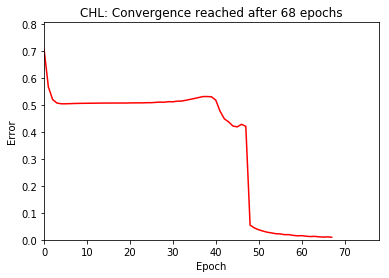

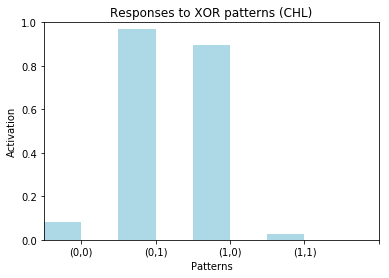

In [11]:
# Plot the Error by epoch

plt.plot(E, color="red")
plt.title("CHL: Convergence reached after %d epochs" %(len(E)))
plt.axis([0, len(E) + 10, 0, max(E + [0.7]) + 0.1])
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

## Plot the responses to the XOR patterns

y_end = [calculate_response(p) for p in patterns]
fig, ax = plt.subplots()
ax.axis([-0.5, 3.5, 0, 1])
ax.set_xticks(np.arange(5))
ax.set_xticklabels(["(%s,%s)" % tuple(p) for p in patterns])
ax.set_ylabel("Activation")
ax.set_xlabel("Patterns")
ax.bar(np.arange(4) - 0.25, y_end, 0.5, color='lightblue')
ax.set_title("Responses to XOR patterns (CHL)")
plt.show()



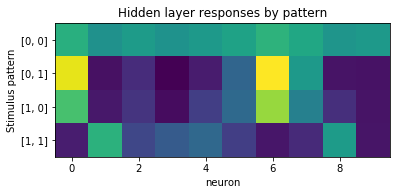

In [12]:
res = np.zeros((len(patterns), h.size))

for p in patterns:
    calculate_response(p)
    i = patterns.index(p) 
    res[i] = h
    
plt.imshow(res, interpolation="nearest")
plt.title("Hidden layer responses by pattern")
plt.yticks(np.arange(4), patterns)
plt.ylabel("Stimulus pattern")
plt.xlabel("neuron")
plt.show()


